In [19]:
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib widget
plt.ioff()

def plot_sets(ax,gr=False,ti='',xla=False,yla=False,zla=False,xli=False,yli=False,zli=False,ticks_off=False,xticks_off=False,yticks_off=False,zticks_off=False, ba=False, ar=False,leg=False,view=False):
    
    ax.set_title(ti)
    if gr:  ax.grid(gr);ax.set_axisbelow(True)
    if xla: ax.set_xlabel(xla)
    if yla: ax.set_ylabel(yla)
    if zla: ax.set_zlabel(zla)

    if xticks_off: ax.set_xticklabels([])
    if yticks_off: ax.set_yticklabels([])
    if zticks_off: ax.set_zticklabels([])

    if   ticks_off==1: ax.set_xticklabels([]); ax.set_xticks([]);ax.set_yticklabels([]); ax.set_yticks([])
    elif ticks_off==2: ax.set_xticklabels([]); ax.set_xticks([])
    elif ticks_off==2: ax.set_yticklabels([]); ax.set_yticks([])

    if ba: ax.set_box_aspect(ba)
    if ar: ax.set_aspect(ar)

    if xli: ax.set_xlim(xli)
    if yli: ax.set_ylim(yli)
    if zli: ax.set_zlim(zli)

    if leg: ax.legend(**leg)

    if view:ax.view_init(**view)

SMALL_SIZE  = 8
MEDIUM_SIZE = 10

# title
plt.rc('axes',titlesize=MEDIUM_SIZE,titleweight='bold')
# xy-labells
plt.rc('axes',labelsize=SMALL_SIZE)
# xy-ticks
plt.rc('xtick',labelsize=SMALL_SIZE)
plt.rc('ytick',labelsize=SMALL_SIZE)
    
px2inch = 1/plt.rcParams['figure.dpi']

### Bezier implementations

In [20]:
# Control pts P
# P = [x1,y1
#      x2,y2
#      x3,y3
#      xn,yn]

# Poly grade = nºpts-1 = P.shape[0]-1

def Binomial(n,i):    
    return math.factorial(n) / ( math.factorial(i)*math.factorial(n-i) )

def Bernstain(n,i,t): 
    return Binomial(n,i) * t**i * (1-t)**(n-i)

def Berstein_Mat(n):
    M = np.zeros((n+1,n+1))
    for i in range(n+1):
        for j in range(n+1):
            if j<=n-i: M[i,j] = Binomial(n,i)*Binomial(n-i,j)*(-1)**(n+i-j)
    return M

def Bezier_loop_form(P,nt=50):
    n  = P.shape[0]-1 
    B  = []
    for t in np.linspace(0,1,nt):
        Bi = np.zeros(2)
        for i,Pi in enumerate(P):
            Bi += Pi*Bernstain(n,i,t)
        B.append([Bi])
    return np.concatenate(B,axis=0)

def Bezier_matrix_form(P,t_param=True,nt=50):
    n = P.shape[0]-1 
    if type(t_param)==bool:       t = np.linspace(0,1,nt).reshape(-1,1) # t equal space   
    if type(t_param)==np.ndarray: t = t_param.reshape(-1,1)             # t not equal space
    T     = t**np.arange(n,-1,-1)
    M     = Berstein_Mat(n)
    return T@M@P

def cumulative_dis(B):
    # B = (nt,2) bezier points
    cum_dis = np.cumsum( np.sqrt( np.sum(np.diff(B,axis=0)**2,axis=1) ) )
    return  np.insert(cum_dis, 0, 0) 


### Bezier Plots

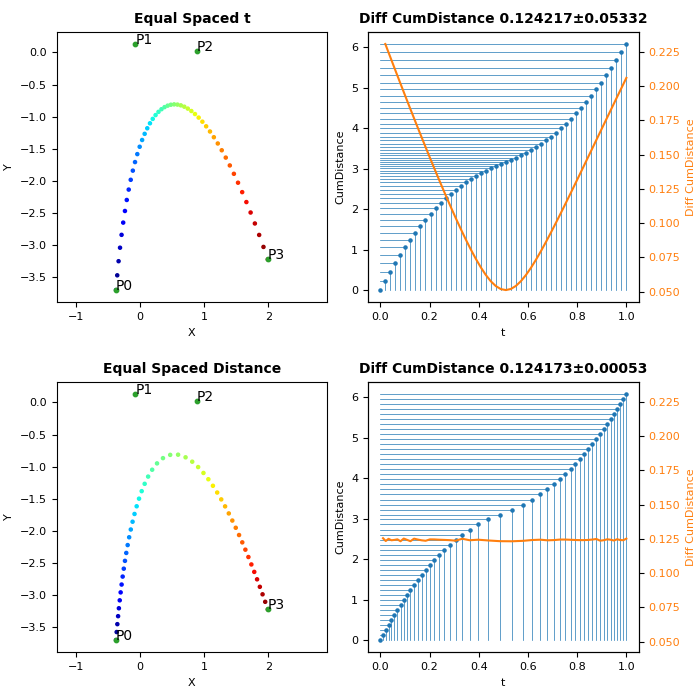

In [21]:
plt.close('all')

# Calc random control points
n    = 3  # poly grade
npts = n+1  # n pts

Px = np.linspace(-1,1,npts).reshape(-1,1)
Py = -4*Px**2
P  = np.concatenate((Px,Py),axis=1) + np.random.rand(npts,2)

# Computed bezier with equal spaced t
nt   = 50
B1   = Bezier_matrix_form(P,nt=nt) 
dis1 = cumulative_dis(B1)

# Obtain a non-uniform time vector that guarantees uniform spacing
t         = np.linspace(0,1,nt)
dis_equal = np.linspace(0,dis1[-1],nt)
t_interp  = np.interp(dis_equal,dis1,t)

# Obtain new Bezier equal spaced points
B2   = Bezier_matrix_form(P,t_param=t_interp)
dis2 = cumulative_dis(B2)

size_plot = 350
size_mark = 5
layout = [[0,2],
          [1,3]]

fig, ax = plt.subplot_mosaic(layout,constrained_layout=True,figsize=(2*size_plot*px2inch,2*size_plot*px2inch))
fig.canvas.toolbar_position = 'right'
fig.canvas.header_visible   = False

def plot_bezier_curve_points(ax,B,P,title='Equal Spaced t'):
    ax.scatter(B[:,0],B[:,1],marker='o',c=t,cmap='jet',s=size_mark  ) # Bezier  Matrix
    ax.scatter(P[:,0],P[:,1],marker='o',c='tab:green' ,s=2*size_mark) # Control Points
    for i,(px,py) in enumerate(P):
        ax.text(px,py,f'P{i}')
        plot_sets(ax,xla='X',yla='Y',ar=1,ti=title,ba=1)

def plot_bezier_distance_diff(ax,t,dist,lims_dis,color_diff='tab:orange'):
    diff_dis = np.diff(dist)
    ax1 = ax.twinx()
    ax1.plot(t[1:],diff_dis,c=color_diff)                                   # Plot t, distance                        
    for ti,di in zip(t,dist):ax.plot([0,ti,ti],[di,di,0],'tab:blue',lw=0.5) # Plot lines   
    ax.scatter(t,dist,marker='o',c='tab:blue',s=size_mark)                  # Plot points
    plot_sets(ax,xla='t',yla='CumDistance',ti=f'Diff CumDistance {np.mean(np.diff(dist)):0.6f}±{np.std(np.diff(dist)):0.5f}',ba=1)
    ax1.set_ylabel('Diff CumDistance', color=color_diff)
    ax1.tick_params(axis='y',labelcolor=color_diff)
    ax1.set_ylim(lims_dis)

diff_dis = np.diff(dis1)
lims_dis = np.array([np.min(diff_dis) ,np.max(diff_dis)]) + np.array([-1,1])*(np.max(diff_dis)-np.min(diff_dis))*0.05

# Subplots

plot_bezier_curve_points(ax[0],B1,P,title='Equal Spaced t')
plot_bezier_curve_points(ax[1],B2,P,title='Equal Spaced Distance')

plot_bezier_distance_diff(ax[2],t       ,dis1,lims_dis)
plot_bezier_distance_diff(ax[3],t_interp,dis2,lims_dis)

plt.show()

In [22]:
# %timeit Bezier_loop(P)
# %timeit Bezier_mat(P)

### Lerps

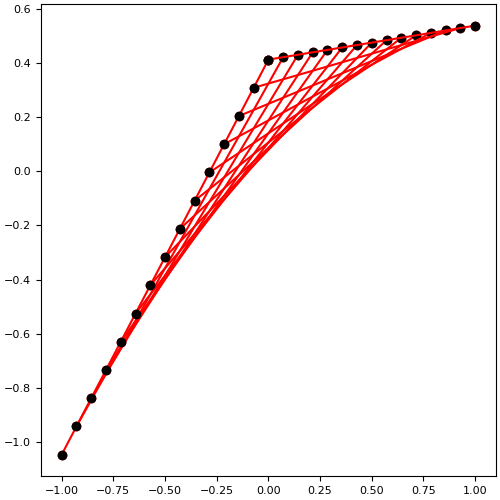

In [23]:

size_plot = 500
fig, ax   = plt.subplots(1,1,constrained_layout=True,figsize=(size_plot*px2inch,size_plot*px2inch))
fig.canvas.toolbar_position = 'right'
fig.canvas.header_visible   = False

# P = [x1,y1
#      x2,y2
#      x3,y3
#      xn,yn]
# Pi = P0 + (P1-P0)*t

n_t = 15
n_p = 3
n_d = n_p-1

Px=np.linspace(-1,1,n_p).reshape(-1,1)
Py=-Px**2 + 0.5*np.random.randn(n_p,1)
P =np.hstack((Px,Py))

for t in np.linspace(0,1,n_t):
    for i in range(n_p-2):
        p1 = P[i,]   + (P[i+1,]-P[i,])*t
        p2 = P[i+1,] + (P[i+2,]-P[i+1,])*t
        ax.plot([p1[0],p2[0]],[p1[1],p2[1]],'ro-')
        ax.plot([p1[0],p2[0]],[p1[1],p2[1]],'ko',mfc='k')
    



plt.show()

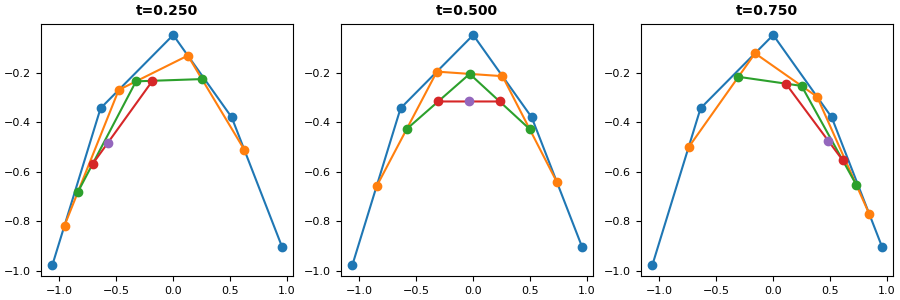

In [25]:
size_plot = 300
fig, ax   = plt.subplots(1,3,constrained_layout=True,figsize=(3*size_plot*px2inch,size_plot*px2inch))
fig.canvas.toolbar_position = 'right'
fig.canvas.header_visible   = False

def bezier(P,t):

    # N    = 5
    # Npts = N+1
    #     -    -    -   -    -
    #     1    2    3   4    5 --> N lerps --> lerp(a,b,t) = a + (b-a)*t
    # P0
    #   --> P
    # P1     --> P
    #   --> P     --> P
    # P2     --> P     --> P
    #   --> P     --> P     --> P
    # P3     --> P     --> P
    #   --> P     --> P
    # P4     --> P
    #   --> P
    # P5

    N  = P.shape[0]-1
    B  = [] 
    B.append(P)
    for i in range(N):  
        B.append( B[i][:-1,:]+np.diff(B[i],axis=0)*t )
    return B

def plot_bezier_(ax,B):
    for b in B: ax.plot(b[:,0],b[:,1],marker='o')

N    = 4
Npts = N+1 
Px   = np.linspace(-1,1,Npts).reshape(-1,1)
P    = np.concatenate((Px,-Px**2),axis=1) + 0.1*np.random.randn(Npts,2)
for i,axi in enumerate(ax):
    ti = 0.25*(i+1)
    plot_bezier_(axi,bezier(P,ti))
    axi.set_title(f't={ti:0.3f}')
plt.show()